# 1 导入期货数据

In [1]:
from pymongo import MongoClient
from datautils.mongodb import read
from datetime import datetime
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jaqs_fxdayu.data.hf_dataview import HFDataView
import warnings
warnings.filterwarnings('ignore')

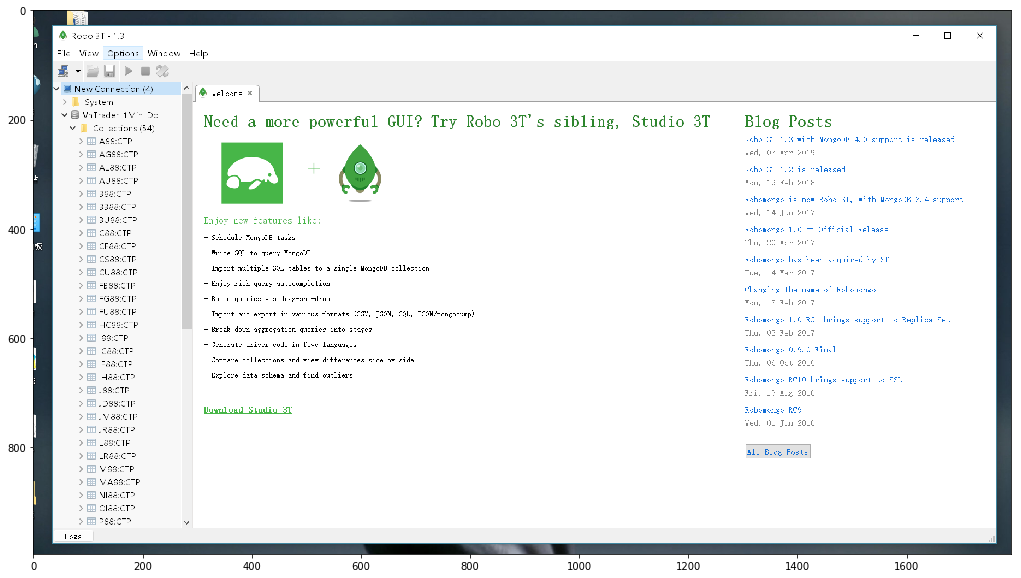

In [2]:
plt.figure(num=2,figsize=(25,10))
d = plt.imread('./导入期货截图.png')
plt.imshow(d)

# 2.1 读取JD88:CTP的数据

In [17]:
client = MongoClient()
IF88 = read(client['VnTrader_1Min_Db']['JD88:CTP'],datetime=(datetime(2018,1,1), datetime(2019,3,21))).set_index('datetime')

In [18]:
def resampleDf(data, freq='H'):
    return data.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
dataResample = resampleDf(IF88, '15Min')

In [19]:
def dt2int(t):
    return t.year*10**10+t.month*10**8+t.day*10**6+t.hour*10**4+t.minute*10**2+t.second

def modifyDf(data, symbol):
    assert isinstance(data, pd.DataFrame)
    data = data.reset_index()
    data['trade_date'] = data['datetime'].apply(dt2int)
    data['symbol'] = symbol
    return data

In [20]:
dataIf = modifyDf(dataResample, 'JD88:CTP')

# 2.2 绘出价格图

In [21]:
dv = HFDataView()
dv.create_init_dv(dataIf.dropna().set_index(['trade_date', 'symbol']))

Initialize dataview success.


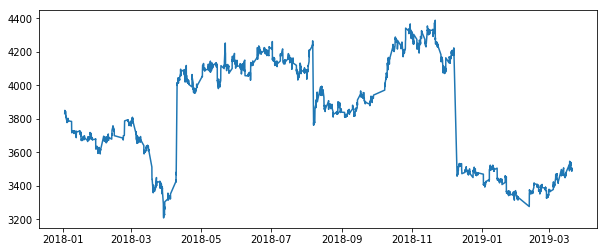

In [82]:
close = dv.get_ts('close', date_type='datetime')
plt.figure(num=2,figsize=(10,4))
plt.plot(close)
plt.show()

# 2.3 绘制jaqs_fxdayu算法图

## 2.3.1 常用技术指标——EMA10 A010001A

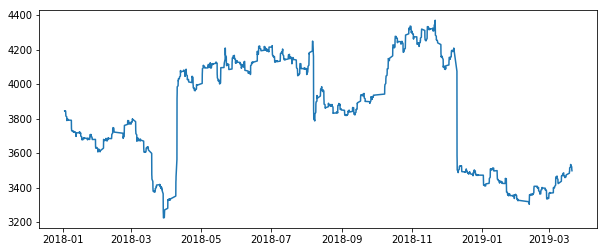

In [83]:
EMA10_J = dv.add_formula('EMA10', "Ta('EMA',0,0,0,0,close,0,10)", add_data=True)
EMA10 = dv.get_ts('EMA10', date_type='datetime')
plt.figure(num = 2, figsize=(10,4))
plt.plot(EMA10)
plt.show()

## 2.3.1 常用技术指标——MA120 A010008A

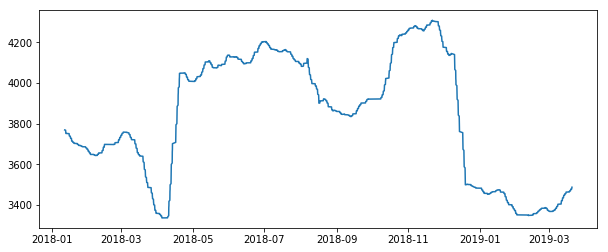

In [84]:
value = dv.add_formula('MA120_A',"Ta('MA',0,0,0,0,close,0,120)", add_data=True)
MA120_A = dv.get_ts('MA120_A', date_type='datetime')
plt.figure(num = 2, figsize=(10,4))
plt.plot(MA120_A)
plt.show()

## 2.3.1 常用技术指标——BBI A010013A

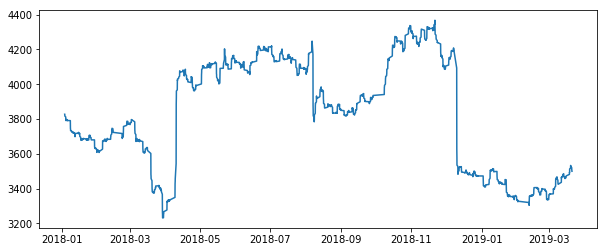

In [85]:
dv.add_formula('MA_3',"Ta('MA',0,0,0,0,close,0,3)",add_data=True)
dv.add_formula('MA_6',"Ta('MA',0,0,0,0,close,0,6)",add_data=True)
dv.add_formula('MA_12',"Ta('MA',0,0,0,0,close,0,12)",add_data=True)
dv.add_formula('MA_24',"Ta('MA',0,0,0,0,close,0,24)",add_data=True)
value = dv.add_formula('BBI_J',"(MA_3+MA_6+MA_12+MA_24)/4",add_data=True)
BBI_J = dv.get_ts('BBI_J', date_type='datetime')
plt.figure(num = 2, figsize=(10,4))
plt.plot(BBI_J)
plt.show()

# 3 计算volume的均值、标准差——JD88:CTP

In [77]:
# volumeDv = dv.get_ts('volume', date_type='datetime')
vol_mean = dv.add_formula('ema', "Ta('EMA',0,0,0,0,close,0,20)", add_data=True)
vol_std = dv.add_formula('std', "Ta('STDDEV',0,0,0,0,close,0,20)", add_data=True)
# vol_mean
DataDf = pd.DataFrame(
                        {
                        'close':dv.get_ts('close', date_type = 'datetime')['JD88:CTP'],
                        'volume':dv.get_ts('volume', date_type = 'datetime')['JD88:CTP'],
                        'vol_mean':dv.get_ts('ema', date_type = 'datetime').get('JD88:CTP'),
                        'vol_std':dv.get_ts('std', date_type = 'datetime').get('JD88:CTP'),
                        }
                      )

Field [ema] is overwritten.
Field [std] is overwritten.


<Figure size 720x288 with 0 Axes>

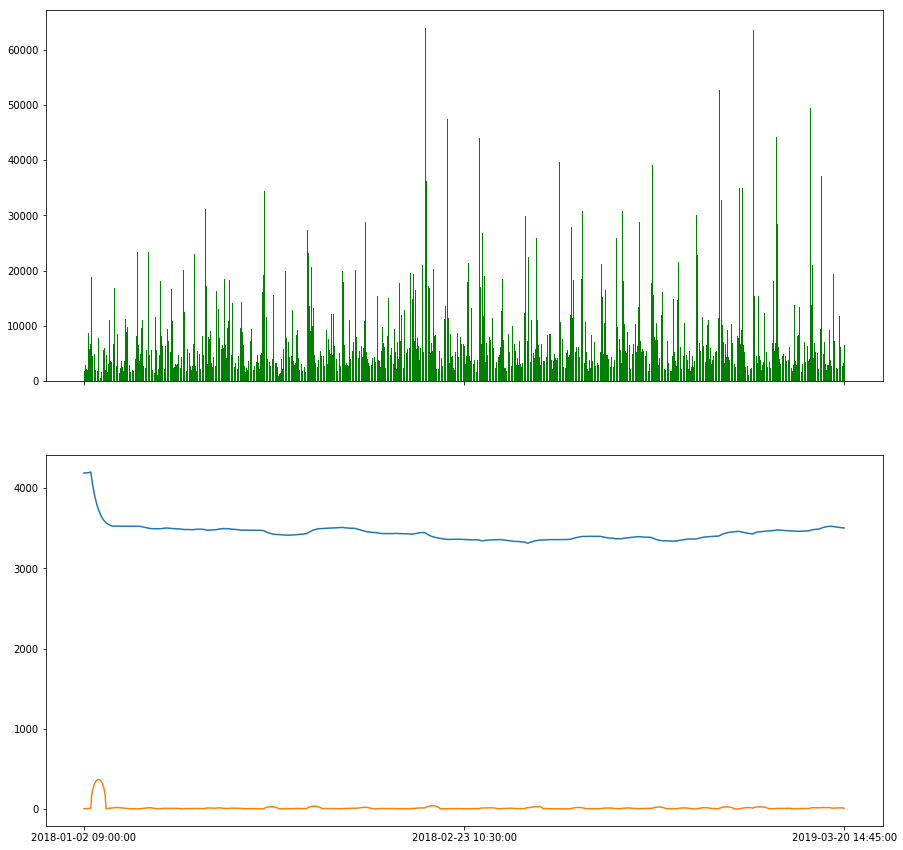

In [81]:
plt.figure(num=2,figsize=(10,4))

dataIf1 = DataDf.reset_index()
dataIf1['tradeDateStr'] = list(map(lambda x: x.strftime(format='%Y-%m-%d %H:%M:%S'), list(dataIf1.trade_date)))
dataIf1.tail()
def chartRange(data, n=100):
    fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
    ax.bar(data.index[-n:], DataDf.volume.iloc[-n:], color='green', width=0.8)
    ax1.plot(data.index[-n:], DataDf.vol_mean.iloc[-n:])
    ax1.plot(data.index[-n:], DataDf.vol_std.iloc[-n:])
    plt.xticks([data.index[-n:][0], data.index[-n:][int(n/2)], data.index[-n:][-1]],
               [data.tradeDateStr.iloc[0],data.tradeDateStr.iloc[int(n/2)], data.tradeDateStr.iloc[-1]])
    plt.show()
    
chartRange(dataIf1, 1000)